In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from newsapi import NewsApiClient
from datetime import datetime, timedelta, timezone
import pytz
import openpyxl
import numpy as np
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Dropout, Dense, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import os

In [55]:
# Set the option to display all rows
pd.set_option('display.max_rows', None)

# Set the option to display all columns
pd.set_option('display.max_columns', None)

In [4]:
# Load the data
# Load the data and convert 'Date' column to datetime
btc_data = pd.read_csv('D:/portfolio_projects/btc_pred_project/BTC-USD.csv', parse_dates=['Date'])

# Sort dataframe by 'Date'
btc_data = btc_data.sort_values(by='Date')


btc_data.head(10)

Date          Open          High           Low         Close  \
0 2023-05-10  27654.636719  28322.687500  26883.669922  27621.755859   
1 2023-05-11  27621.085938  27621.941406  26781.826172  27000.789063   
2 2023-05-12  26987.662109  27055.646484  25878.429688  26804.990234   
3 2023-05-13  26807.769531  27030.482422  26710.873047  26784.078125   
4 2023-05-14  26788.974609  27150.976563  26661.355469  26930.638672   
5 2023-05-15  26931.384766  27646.347656  26766.097656  27192.693359   
6 2023-05-16  27171.513672  27299.304688  26878.947266  27036.650391   
7 2023-05-17  27035.470703  27465.927734  26600.144531  27398.802734   
8 2023-05-18  27401.650391  27466.527344  26415.101563  26832.208984   
9 2023-05-19  26826.753906  27128.619141  26700.210938  26890.128906   

      Adj Close       Volume  
0  27621.755859  20656025026  
1  27000.789063  16724343943  
2  26804.990234  19313599897  
3  26784.078125   9999171605  
4  26930.638672  10014858959  
5  27192.693359  14413231792  
6  27036.650391  12732238816  
7  27398.802734  15140006925  
8  26832.208984  15222938600  
9  26890.128906  11258983301

In [5]:
# Summary statistics
print(btc_data.describe())

# Check for missing values
print(btc_data.isnull().sum())

               Open          High           Low         Close     Adj Close  \
count     93.000000     93.000000     93.000000     93.000000     93.000000   
mean   28511.128675  28896.710329  28156.613197  28530.207955  28530.207955   
std     1714.937352   1729.445125   1751.939793   1713.400201   1713.400201   
min    25121.673828  25735.308594  24797.167969  25124.675781  25124.675781   
25%    26871.158203  27265.917969  26621.140625  26868.353516  26868.353516   
50%    29161.812500  29353.160156  28934.294922  29176.916016  29176.916016   
75%    30086.187500  30427.589844  29777.285156  30086.246094  30086.246094   
max    31474.720703  31814.515625  30659.355469  31476.048828  31476.048828   

             Volume  
count  9.300000e+01  
mean   1.395357e+10  
std    4.770365e+09  
min    6.481776e+09  
25%    1.097279e+10  
50%    1.324016e+10  
75%    1.583738e+10  
max    3.334676e+10  
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0


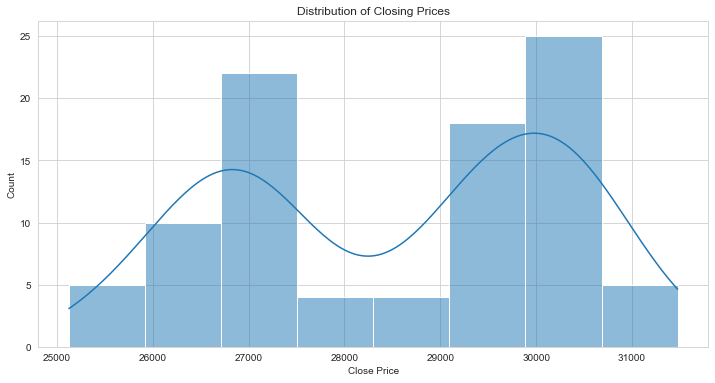

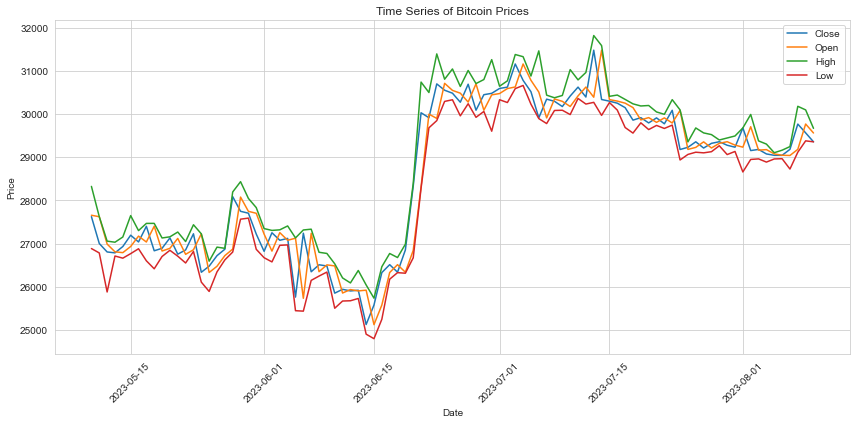

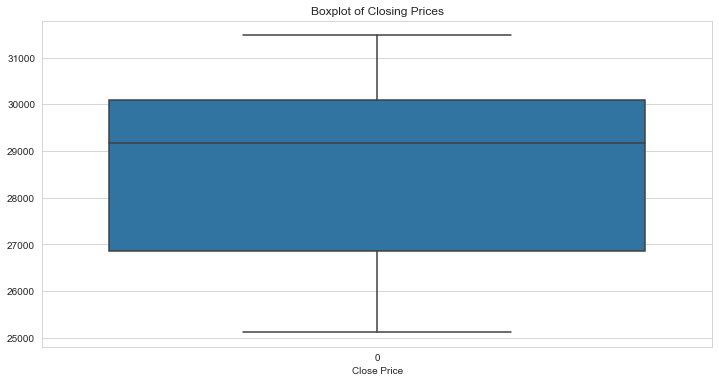

In [6]:
# Set style
sns.set_style("whitegrid")

# Distribution of Closing Prices
plt.figure(figsize=(12, 6))
sns.histplot(btc_data['Close'], kde=True)
plt.title('Distribution of Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Count')
plt.show()

# Time Series of Closing, Open, High, and Low Prices
plt.figure(figsize=(12, 6))
sns.lineplot(data=btc_data, x='Date', y='Close', label='Close')
sns.lineplot(data=btc_data, x='Date', y='Open', label='Open')
sns.lineplot(data=btc_data, x='Date', y='High', label='High')
sns.lineplot(data=btc_data, x='Date', y='Low', label='Low')
plt.title('Time Series of Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Box plot to understand statistical summary of Close Price
plt.figure(figsize=(12, 6))
sns.boxplot(btc_data['Close'])
plt.title('Boxplot of Closing Prices')
plt.xlabel('Close Price')
plt.show()


In [7]:
# Initialize the client
api_key = os.getenv('NEWSAPI_KEY')
newsapi = NewsApiClient(api_key=api_key)

# Define a list of reputable US sources (you can modify this list as needed)
reliable_sources = [
    'abc-news', 'bloomberg', 'business-insider', 'cbs-news', 'cnn', 
    'fox-news', 'msnbc', 'national-geographic', 'nbc-news', 'newsweek', 
    'new-york-magazine', 'reuters', 'the-huffington-post', 'the-wall-street-journal', 
    'the-washington-post', 'time', 'usa-today', 'vice-news', 'wired', 'forbes'
]

# Loop through the past 30 days
all_articles = []
for i in range(30):
    date = (datetime.now() - timedelta(days=i)).strftime('%Y-%m-%d')

    # Make the API call for the specific date
    articles = newsapi.get_everything(q='bitcoin',
                                      from_param=date,
                                      to=date,
                                      sources=','.join(reliable_sources),
                                      language='en',
                                      sort_by='publishedAt',
                                      page_size=5)  # fetch 5 articles per day
                                      
    all_articles.extend(articles['articles'])

# Print out the articles
for article in all_articles:
    print(article['title'], "-", article['source']['name'])

US stocks fall as investors brace for July CPI report - Business Insider
US stocks slip as investors struggle to recover from sell-off ahead of key inflation report - Business Insider
US stocks drop as bank shares slide after Moody's downgrades 10 firms - Business Insider
Here's what CEOs are saying about consumer spending - CNN
PayPal's latest crypto play is a stablecoin pegged to the US dollar - Business Insider
US stocks rise as investors digest 2nd-quarter earnings beats - Business Insider
PayPal launches digital token in push to capture crypto payments - The Washington Post
Tesla's CFO and 'Master of Coin' is leaving the company - CNN
US stocks rise as investors turn attention to upcoming inflation data - Business Insider
Does anyone care about crypto? Consumer transaction volume on Coinbase is down 70% from last year. - Business Insider
Security News This Week: The Cloud Company at the Center of a Global Hacking Spree - Wired
'This isn't some random dude with a duffel bag': To ca

In [8]:
# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(all_articles)

# Since the 'source' column itself contains dictionaries with 'id' and 'name', 
# we can create separate columns for them
df['source_id'] = df['source'].apply(lambda x: x['id'])
df['source_name'] = df['source'].apply(lambda x: x['name'])
df = df.drop(columns=['source'])

# Display the DataFrame
print(df.head())

                                     author  \
0           jsor@insider.com (Jennifer Sor)   
1           jsor@insider.com (Jennifer Sor)   
2                                Phil Rosen   
3                               Krystal Hur   
4  ztayeb@businessinsider.com (Zahra Tayeb)   

                                               title  \
0  US stocks fall as investors brace for July CPI...   
1  US stocks slip as investors struggle to recove...   
2  US stocks drop as bank shares slide after Mood...   
3  Here's what CEOs are saying about consumer spe...   
4  PayPal's latest crypto play is a stablecoin pe...   

                                         description  \
0  August has been tough for investors, with stoc...   
1  Stocks dipped again, extending losses after a ...   
2  The ratings giant slashed the ratings for 10 l...   
3  Consumer resilience has helped keep the econom...   
4  The stablecoin, named PayPal USD (PYUSD), aims...   

                                           

In [9]:
df['publishedAt'].min()

'2023-07-12T12:15:44Z'

In [10]:
df['publishedAt'].max()

'2023-08-09T20:04:16Z'

In [11]:
# Assuming df is your DataFrame
# Convert the 'publishedAt' column to datetime
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

# Convert from UTC to Eastern Daylight Time (EDT)
eastern = pytz.timezone('US/Eastern')
df['publishedAt'] = df['publishedAt'].dt.tz_convert(eastern)

# Extract the date and format it as YYYY-MM-DD
df['publishedAt'] = df['publishedAt'].dt.date

# Now the 'publishedAt' column is in the desired format
print(df.head())

                                     author  \
0           jsor@insider.com (Jennifer Sor)   
1           jsor@insider.com (Jennifer Sor)   
2                                Phil Rosen   
3                               Krystal Hur   
4  ztayeb@businessinsider.com (Zahra Tayeb)   

                                               title  \
0  US stocks fall as investors brace for July CPI...   
1  US stocks slip as investors struggle to recove...   
2  US stocks drop as bank shares slide after Mood...   
3  Here's what CEOs are saying about consumer spe...   
4  PayPal's latest crypto play is a stablecoin pe...   

                                         description  \
0  August has been tough for investors, with stoc...   
1  Stocks dipped again, extending losses after a ...   
2  The ratings giant slashed the ratings for 10 l...   
3  Consumer resilience has helped keep the econom...   
4  The stablecoin, named PayPal USD (PYUSD), aims...   

                                           

In [12]:
df['publishedAt'].min()

datetime.date(2023, 7, 12)

In [13]:
df['publishedAt'].max()

datetime.date(2023, 8, 9)

In [14]:
btc_trunc = btc_data[ (btc_data['Date'] >= '2023-7-12') & (btc_data['Date'] <= '2023-8-9')]
btc_trunc.head()

Date          Open          High           Low         Close  \
63 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
64 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
65 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
66 2023-07-15  30331.783203  30407.781250  30263.462891  30295.806641   
67 2023-07-16  30297.472656  30437.560547  30089.669922  30249.132813   

       Adj Close       Volume  
63  30391.646484  14805659717  
64  31476.048828  23686079548  
65  30334.068359  20917902660  
66  30295.806641   8011667756  
67  30249.132813   8516564470

In [15]:
btc_trunc.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [16]:
df.dtypes

author         object
title          object
description    object
url            object
urlToImage     object
publishedAt    object
content        object
source_id      object
source_name    object
dtype: object

In [17]:
# Convert the 'publishedAt' column in df to string format
df['publishedAt'] = df['publishedAt'].astype(str)
btc_trunc['Date'] = btc_trunc['Date'].astype(str)
# Perform the left join
merged_df = btc_trunc.merge(df, left_on='Date', right_on='publishedAt', how='left')

# Check the result
merged_df.head()


D:\Anaconda\envs\spyder-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Date          Open          High           Low         Close  \
0  2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1  2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
2  2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
3  2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
4  2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   

      Adj Close       Volume                                    author  \
0  30391.646484  14805659717                              Jennifer Sor   
1  30391.646484  14805659717            Kurt Knutsson, CyberGuy Report   
2  30391.646484  14805659717                              Jennifer Sor   
3  30391.646484  14805659717  ztayeb@businessinsider.com (Zahra Tayeb)   
4  31476.048828  23686079548    mfox@businessinsider.com (Matthew Fox)   

                                               title  \
0  US stocks climb as traders hope cooler June in...   
1  This quick trick lets you copy text from any i...   
2  US stocks jump as investors cheer lowest infla...   
3  'Rich Dad Poor Dad' author Robert Kiyosaki war...   
4  XRP soars 61% after a judge says the cryptocur...   

                                         description  \
0  Bets that the Federal Reserve will pause rate ...   
1  Smartphones have a feature that allows you to ...   
2  Inflation dropped to 3% in June, marking the l...   
3  Recently, the Russian embassy in Kenya said th...   
4  Crypto-linked stocks like Coinbase and Riot Bl...   

                                                 url  \
0  https://markets.businessinsider.com/news/stock...   
1  https://www.foxnews.com/tech/quick-trick-copy-...   
2  https://markets.businessinsider.com/news/stock...   
3  https://markets.businessinsider.com/news/stock...   
4  https://markets.businessinsider.com/news/commo...   

                                          urlToImage publishedAt  \
0  https://i.insider.com/5eb59db41441927acb5792f6...  2023-07-12   
1  https://static.foxnews.com/foxnews.com/content...  2023-07-12   
2  https://i.insider.com/5a87472ed03072fc098b47fc...  2023-07-12   
3  https://i.insider.com/645b44a8c726bc00196aad14...  2023-07-12   
4  https://i.insider.com/64b02d51c22d1a0019454eba...  2023-07-13   

                                             content         source_id  \
0  Getty Images / Bryan R. Smith\r\n<ul>\n<li>US ...  business-insider   
1  Have you ever captured a photo of a sign or po...          fox-news   
2  JOHANNES EISELE/Getty Images\r\n<ul>\n<li>Head...  business-insider   
3  "Rich Dad Poor Dad" author Robert Kiyosaki iss...  business-insider   
4  XRP soared as much as 61% on Thursday after a ...  business-insider   

        source_name  
0  Business Insider  
1          Fox News  
2  Business Insider  
3  Business Insider  
4  Business Insider

In [18]:
merged_df.shape

(87, 16)

In [19]:
# Drop the 'publishedAt' column
merged_df.drop(columns=['publishedAt'], inplace=True)

# Convert the 'Date' column back to datetime object
merged_df['Date'] = pd.to_datetime(merged_df['Date'])




In [144]:
# Save the resulting DataFrame to an Excel file
#merged_df.to_excel('merged_df.xlsx', index=False)

In [9]:
### START FROM HERE


#merged_df = pd.read_excel('merged_df.xlsx', engine='openpyxl')

In [20]:
print(merged_df.dtypes)
print(merged_df.head(3))


Date           datetime64[ns]
Open                  float64
High                  float64
Low                   float64
Close                 float64
Adj Close             float64
Volume                  int64
author                 object
title                  object
description            object
url                    object
urlToImage             object
content                object
source_id              object
source_name            object
dtype: object
        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
2 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   

      Adj Close       Volume                          author  \
0  30391.646484  14805659717                    Jennifer Sor   
1  30391.646484  14805659717  Kurt Knutsson, CyberGuy Report   
2  30391.646484  14805659717                    Jennife

In [21]:
merged_df['description'].head(10)

0    Bets that the Federal Reserve will pause rate ...
1    Smartphones have a feature that allows you to ...
2    Inflation dropped to 3% in June, marking the l...
3    Recently, the Russian embassy in Kenya said th...
4    Crypto-linked stocks like Coinbase and Riot Bl...
5    The producer price index for June climbed 0.1%...
6    Central America is experiencing a wave of unre...
7    Earnings results from JPMorgan, Wells Fargo, a...
8    Alex Mashinsky, the former CEO of collapsed cr...
9    Federal officials this week charged Andrew Ven...
Name: description, dtype: object

In [22]:
len(merged_df['source_name'].unique())

13

In [23]:
merged_df.head()

Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
2 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
3 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
4 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   

      Adj Close       Volume                                    author  \
0  30391.646484  14805659717                              Jennifer Sor   
1  30391.646484  14805659717            Kurt Knutsson, CyberGuy Report   
2  30391.646484  14805659717                              Jennifer Sor   
3  30391.646484  14805659717  ztayeb@businessinsider.com (Zahra Tayeb)   
4  31476.048828  23686079548    mfox@businessinsider.com (Matthew Fox)   

                                               title  \
0  US stocks climb as traders hope cooler June in...   
1  This quick trick lets you copy text from any i...   
2  US stocks jump as investors cheer lowest infla...   
3  'Rich Dad Poor Dad' author Robert Kiyosaki war...   
4  XRP soars 61% after a judge says the cryptocur...   

                                         description  \
0  Bets that the Federal Reserve will pause rate ...   
1  Smartphones have a feature that allows you to ...   
2  Inflation dropped to 3% in June, marking the l...   
3  Recently, the Russian embassy in Kenya said th...   
4  Crypto-linked stocks like Coinbase and Riot Bl...   

                                                 url  \
0  https://markets.businessinsider.com/news/stock...   
1  https://www.foxnews.com/tech/quick-trick-copy-...   
2  https://markets.businessinsider.com/news/stock...   
3  https://markets.businessinsider.com/news/stock...   
4  https://markets.businessinsider.com/news/commo...   

                                          urlToImage  \
0  https://i.insider.com/5eb59db41441927acb5792f6...   
1  https://static.foxnews.com/foxnews.com/content...   
2  https://i.insider.com/5a87472ed03072fc098b47fc...   
3  https://i.insider.com/645b44a8c726bc00196aad14...   
4  https://i.insider.com/64b02d51c22d1a0019454eba...   

                                             content         source_id  \
0  Getty Images / Bryan R. Smith\r\n<ul>\n<li>US ...  business-insider   
1  Have you ever captured a photo of a sign or po...          fox-news   
2  JOHANNES EISELE/Getty Images\r\n<ul>\n<li>Head...  business-insider   
3  "Rich Dad Poor Dad" author Robert Kiyosaki iss...  business-insider   
4  XRP soared as much as 61% on Thursday after a ...  business-insider   

        source_name  
0  Business Insider  
1          Fox News  
2  Business Insider  
3  Business Insider  
4  Business Insider

In [24]:
# Dropping unnecessary columns
dfx = merged_df.drop(['Adj Close', 'url', 'urlToImage', 'source_id', 'author'], axis=1)

# Drop rows containing NaN values in 'title', 'description', and 'content' columns
dfx.dropna(subset=['title', 'description', 'content'], inplace=True)

# Grouping by Date and aggregating the required columns
grouped_df = dfx.groupby('Date').agg({
    'Open': 'mean',
    'High': 'mean',
    'Low': 'mean',
    'Close': 'mean',
    'Volume': 'mean',
    'title': lambda x: ' '.join(x),
    'description': lambda x: ' '.join(x),
    'content': lambda x: ' '.join(x),
}).reset_index()

# Adding source name counts
source_counts = dfx.groupby(['Date', 'source_name']).size().unstack(fill_value=0).reset_index()
final_df = pd.merge(grouped_df, source_counts, how='left', on='Date')

# Resulting DataFrame
print(final_df.head())


        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4 2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   

        Volume                                              title  \
0  14805659717  US stocks climb as traders hope cooler June in...   
1  23686079548  XRP soars 61% after a judge says the cryptocur...   
2  20917902660  A wave of political turbulence is rolling thro...   
3  13240156074  US stocks rally as recession fears ease and in...   
4  13138897269  Dow extends winning streak to 7 days as US sto...   

                                         description  \
0  Bets that the Federal Reserve will pause rate ...   
1  Crypto-linked stocks like Coinbase an

In [25]:
final_df['Date'].max()

Timestamp('2023-08-09 00:00:00')

In [26]:
# Selecting only the numeric columns (excluding the target 'Close')
df_num = final_df[['Close','Open','High','Low','Date'] + [col for col in final_df.columns if final_df[col].dtype == 'int64']]
df_num.head(10)

Close          Open          High           Low       Date  \
0  30391.646484  30622.246094  30959.964844  30228.835938 2023-07-12   
1  31476.048828  30387.488281  31814.515625  30268.351563 2023-07-13   
2  30334.068359  31474.720703  31582.253906  29966.386719 2023-07-14   
3  30145.888672  30249.626953  30336.400391  29685.783203 2023-07-17   
4  29856.562500  30147.070313  30233.656250  29556.427734 2023-07-18   
5  29913.923828  29862.046875  30184.181641  29794.269531 2023-07-19   
6  29792.015625  29915.250000  30195.531250  29638.095703 2023-07-20   
7  29908.744141  29805.111328  30045.998047  29733.851563 2023-07-21   
8  29771.802734  29908.697266  29991.615234  29664.121094 2023-07-22   
9  30084.539063  29790.111328  30330.640625  29741.527344 2023-07-23   

        Volume  ABC News  Business Insider  CNN  Fox News  NBC News  \
0  14805659717         0                 3    0         1         0   
1  23686079548         0                 2    0         0         0   
2  20917902660         1                 1    1         1         0   
3  13240156074         0                 3    0         0         0   
4  13138897269         0                 2    0         0         0   
5  12128602812         0                 1    0         0         0   
6  14655207121         0                 2    0         0         0   
7  10972789818         3                 3    0         0         0   
8   7873300598         0                 1    0         1         0   
9   9220145050         0                 1    0         0         0   

   New York Magazine  Newsweek  Reuters  The Washington Post  Time  USA Today  \
0                  0         0        0                    0     0          0   
1                  0         0        0                    0     0          0   
2                  0         0        0                    0     0          0   
3                  0         0        0                    0     0          0   
4                  0         0        0                    0     0          0   
5                  0         0        1                    0     0          0   
6                  0         0        1                    0     1          0   
7                  0         0        0                    0     0          2   
8                  0         0        0                    0     0          0   
9                  0         0        0                    0     0          0   

   Wired  
0      0  
1      0  
2      1  
3      0  
4      0  
5      0  
6      0  
7      0  
8      0  
9      0

In [27]:
# run everytime before modelling
df_ts = df_num.copy()

# Extract the day of the week (0 = Monday, 6 = Sunday)
df_ts['Day_of_Week'] = df_ts['Date'].dt.dayofweek

# Create lagged features for Volume, High, Low, and Close
df_ts['Volume_Lag1'] = df_ts['Volume'].shift(1)
df_ts['High_Lag1'] = df_ts['High'].shift(1)
df_ts['Low_Lag1'] = df_ts['Low'].shift(1)
df_ts['Close_Lag1'] = df_ts['Close'].shift(1)

# Drop the first row with NaN lagged features
df_ts.dropna(inplace=True)

# Features and target
X = df_ts.drop(['Close', 'Date', 'Open', 'High', 'Low', 'Volume'], axis=1)
y = df_ts['Close']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Model architecture
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')

# Train the model with the early stopping callback
history = model.fit(X_train_scaled, y_train_scaled,
                    epochs=30,
                    batch_size=6,
                    validation_data=(X_test_scaled, y_test_scaled),
                    callbacks=[early_stopping])

# Prediction for the last available date (Aug 8th)
last_data_point = X[-3:].values
last_data_point_scaled = scaler_X.transform(last_data_point).reshape(3, 1, X_train_scaled.shape[2])
predicted_close_scaled = model.predict(last_data_point_scaled)
predicted_close = scaler_y.inverse_transform(predicted_close_scaled).flatten()

print(f"Predicted close prices for August 10th, 11th, 12th, 2023: {predicted_close}")


Epoch 1/30
3/3 [==============================] - 2s 121ms/step - loss: 1.0128 - val_loss: 0.7931
Epoch 2/30
3/3 [==============================] - 0s 17ms/step - loss: 0.9782 - val_loss: 0.7812
Epoch 3/30
3/3 [==============================] - 0s 15ms/step - loss: 0.9488 - val_loss: 0.7709
Epoch 4/30
3/3 [==============================] - 0s 15ms/step - loss: 0.9274 - val_loss: 0.7591
Epoch 5/30
3/3 [==============================] - 0s 14ms/step - loss: 0.9020 - val_loss: 0.7485
Epoch 6/30
3/3 [==============================] - 0s 15ms/step - loss: 0.8805 - val_loss: 0.7390
Epoch 7/30
3/3 [==============================] - 0s 15ms/step - loss: 0.8523 - val_loss: 0.7232
Epoch 8/30
3/3 [==============================] - 0s 14ms/step - loss: 0.8170 - val_loss: 0.7021
Epoch 9/30
3/3 [==============================] - 0s 15ms/step - loss: 0.7852 - val_loss: 0.6812
Epoch 10/30
3/3 [==============================] - 0s 15ms/step - loss: 0.7516 - val_loss: 0.6542
Epoch 11/30
3/3 [===========

D:\Anaconda\envs\spyder-env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


1/1 [==============================] - 0s 184ms/step
Predicted close prices for August 10th, 11th, 12th, 2023: [29481.604 29320.162 29568.455]


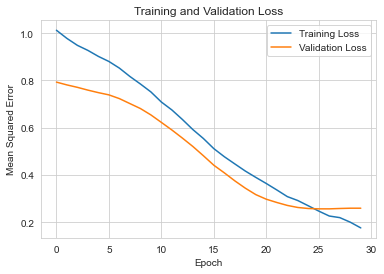

In [28]:
# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [47]:
# run everytime before modelling
df_ts = df_num.copy()
df_ts.dtypes

# Extract the day of the week (0 = Monday, 6 = Sunday)
df_ts['Day_of_Week'] = df_ts['Date'].dt.dayofweek

# Create lagged features for Volume, High, Low, and Close
df_ts['Volume_Lag1'] = df_ts['Volume'].shift(1)
df_ts['High_Lag1'] = df_ts['High'].shift(1)
df_ts['Low_Lag1'] = df_ts['Low'].shift(1)
df_ts['Close_Lag1'] = df_ts['Close'].shift(1)

# Drop the first row with NaN lagged features
df_ts.dropna(inplace=True)

# Features and target
X = df_ts.drop(['Close', 'Date', 'Open', 'High', 'Low', 'Volume'], axis=1)
y = df_ts['Close']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [48]:
def create_model():
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Define the batch sizes to test
param_grid = {'batch_size': [1, 2, 3, 4, 5, 6], 'epochs': [30]}

# Wrap the Keras model with KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Create a GridSearchCV instance with k-fold cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3) # 3-fold cross-validation

# Fit the GridSearchCV instance to the data
grid_result = grid.fit(X_train_scaled, y_train_scaled)

# Print the best result
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')

# Train the best model to save the history
best_model = create_model()
history = best_model.fit(X_train_scaled, y_train_scaled,
                         epochs=30,
                         batch_size=grid_result.best_params_['batch_size'],
                         validation_data=(X_test_scaled, y_test_scaled),
                         callbacks=[early_stopping])

D:\Anaconda\envs\spyder-env\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  from ipykernel import kernelapp as app


Best: -0.764765073855718 using {'batch_size': 2, 'epochs': 30}
Epoch 1/60
10/10 [==============================] - 2s 25ms/step - loss: 0.9814 - val_loss: 0.6846
Epoch 2/60
10/10 [==============================] - 0s 5ms/step - loss: 0.9368 - val_loss: 0.6784
Epoch 3/60
10/10 [==============================] - 0s 5ms/step - loss: 0.9018 - val_loss: 0.6486
Epoch 4/60
10/10 [==============================] - 0s 5ms/step - loss: 0.8524 - val_loss: 0.6096
Epoch 5/60
10/10 [==============================] - 0s 5ms/step - loss: 0.7977 - val_loss: 0.5545
Epoch 6/60
10/10 [==============================] - 0s 5ms/step - loss: 0.7383 - val_loss: 0.5096
Epoch 7/60
10/10 [==============================] - 0s 5ms/step - loss: 0.6611 - val_loss: 0.4449
Epoch 8/60
10/10 [==============================] - 0s 5ms/step - loss: 0.5635 - val_loss: 0.3727
Epoch 9/60
10/10 [==============================] - 0s 5ms/step - loss: 0.4902 - val_loss: 0.2937
Epoch 10/60
10/10 [==============================] - 0

In [49]:
# Prepare the last 3 data points for prediction
last_data_point = X[-3:].values
last_data_point_scaled = scaler_X.transform(last_data_point).reshape(3, 1, X_train_scaled.shape[2])

# Make predictions using the best model
predicted_close_scaled = best_model.predict(last_data_point_scaled)

# Inverse transform the scaled predictions
predicted_close = scaler_y.inverse_transform(predicted_close_scaled).flatten()

# Print the predicted close prices
print(f"Predicted close prices for August 10th, 11th, 12th, 2023: {predicted_close}")


1/1 [==============================] - 0s 147ms/step
Predicted close prices for August 10th, 11th, 12th, 2023: [29446.771 29383.473 29429.457]


D:\Anaconda\envs\spyder-env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


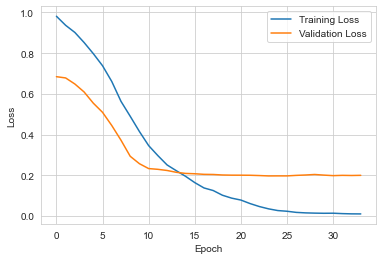

In [50]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
print(final_df.head(10))

        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4 2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   
5 2023-07-19  29862.046875  30184.181641  29794.269531  29913.923828   
6 2023-07-20  29915.250000  30195.531250  29638.095703  29792.015625   
7 2023-07-21  29805.111328  30045.998047  29733.851563  29908.744141   
8 2023-07-22  29908.697266  29991.615234  29664.121094  29771.802734   
9 2023-07-23  29790.111328  30330.640625  29741.527344  30084.539063   

        Volume                                              title  \
0  14805659717  US stocks climb as traders hope cooler June in...   
1  23686079548  XRP soars 61% after a judge says the cryptocur...   


In [59]:
tdf = final_df.drop(columns=['content', 'description'])
print(tdf.head())

        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4 2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   

        Volume                                              title  ABC News  \
0  14805659717  US stocks climb as traders hope cooler June in...         0   
1  23686079548  XRP soars 61% after a judge says the cryptocur...         0   
2  20917902660  A wave of political turbulence is rolling thro...         1   
3  13240156074  US stocks rally as recession fears ease and in...         0   
4  13138897269  Dow extends winning streak to 7 days as US sto...         0   

   Business Insider  CNN  Fox News  NBC News  New York Magazine  Newsweek  \
0              

In [36]:
# Create a sentiment-analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


D:\Anaconda\envs\spyder-env\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [60]:
# Group by 'Date' and concatenate titles for each date
tdf1 = tdf.groupby('Date').agg({
    'Open': 'first',
    'High': 'first',
    'Low': 'first',
    'Close': 'first',
    'Volume': 'first',
    'title': ' '.join  # Concatenate titles
}).reset_index()

# Renaming the 'title' column to 'titles'
tdf1.rename(columns={'title': 'titles'}, inplace=True)


In [61]:
tdf1

Date          Open          High           Low         Close  \
0  2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1  2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2  2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3  2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4  2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   
5  2023-07-19  29862.046875  30184.181641  29794.269531  29913.923828   
6  2023-07-20  29915.250000  30195.531250  29638.095703  29792.015625   
7  2023-07-21  29805.111328  30045.998047  29733.851563  29908.744141   
8  2023-07-22  29908.697266  29991.615234  29664.121094  29771.802734   
9  2023-07-23  29790.111328  30330.640625  29741.527344  30084.539063   
10 2023-07-24  30081.662109  30093.394531  28934.294922  29176.916016   
11 2023-07-25  29178.970703  29353.160156  29062.433594  29227.390625   
12 2023-07-26  29225.759766  29675.552734  29113.912109  29354.972656   
13 2023-07-27  29353.798828  29560.966797  29099.351563  29210.689453   
14 2023-07-28  29212.164063  29521.513672  29125.845703  29319.246094   
15 2023-07-29  29319.445313  29396.843750  29264.166016  29356.917969   
16 2023-07-31  29278.314453  29489.873047  29131.578125  29230.111328   
17 2023-08-01  29230.873047  29675.732422  28657.023438  29675.732422   
18 2023-08-02  29704.146484  29987.998047  28946.509766  29151.958984   
19 2023-08-03  29161.812500  29375.707031  28959.488281  29178.679688   
20 2023-08-04  29174.382813  29302.078125  28885.335938  29074.091797   
21 2023-08-05  29075.388672  29102.464844  28957.796875  29042.126953   
22 2023-08-07  29038.513672  29244.281250  28724.140625  29180.578125   
23 2023-08-08  29180.019531  30176.796875  29113.814453  29765.492188   
24 2023-08-09  29766.695313  30093.435547  29376.800781  29561.494141   

         Volume                                             titles  
0   14805659717  US stocks climb as traders hope cooler June in...  
1   23686079548  XRP soars 61% after a judge says the cryptocur...  
2   20917902660  A wave of political turbulence is rolling thro...  
3   13240156074  US stocks rally as recession fears ease and in...  
4   13138897269  Dow extends winning streak to 7 days as US sto...  
5   12128602812  Dow hits 8-day winning streak as investors hop...  
6   14655207121  Dow notches 9-day win streak while earnings fr...  
7   10972789818  A Nevada woman who hired a hitman using bitcoi...  
8    7873300598  How to block those unwanted and annoying spam ...  
9    9220145050  A bitcoin positive-feedback loop could more th...  
10  15395817395  Dow notches 11th straight win as traders look ...  
11  10266772793  RFK Jr's Bitcoin Proposal for U.S. Dollar Tras...  
12  13497554655  Dow notches longest winning streak since 1987 ...  
13  10770779217  Dow snaps historic win streak as US stocks fal...  
14  11218474952  When do new 'Futurama' episodes come out? Cast...  
15   6481775959  Russia's bitcoin mining industry is booming th...  
16  11656781982  Ron DeSantis unveils economic plans echoing Do...  
17  18272392391  US stocks trade mixed amid earnings rush and f...  
18  19212655598  US stocks fall as Dow sheds nearly 350 points ...  
19  12780357746  US stocks fall as bond yields jump and investo...  
20  12036639988  US stocks fall after erasing earlier gains as ...  
21   6598366353  Does anyone care about crypto? Consumer transa...  
22  13618163710  US stocks rise as investors digest 2nd-quarter...  
23  17570561357  US stocks drop as bank shares slide after Mood...  
24  18379521213  US stocks fall as investors brace for July CPI...

In [62]:
def get_sentiment(text):
    result = sentiment_analyzer(text)
    return result[0]['label'], result[0]['score']

# Apply the function to the title column
tdf1['sentiment'], tdf1['sentiment_score'] = zip(*tdf1['titles'].apply(get_sentiment))

In [64]:
print(tdf1.head())

        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4 2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   

        Volume                                             titles sentiment  \
0  14805659717  US stocks climb as traders hope cooler June in...  NEGATIVE   
1  23686079548  XRP soars 61% after a judge says the cryptocur...  NEGATIVE   
2  20917902660  A wave of political turbulence is rolling thro...  NEGATIVE   
3  13240156074  US stocks rally as recession fears ease and in...  NEGATIVE   
4  13138897269  Dow extends winning streak to 7 days as US sto...  NEGATIVE   

   sentiment_score  
0         0.997129  
1         0.947194  
2         0.890904  
3       

In [67]:
col_names = tdf.columns.tolist()
col_names

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'title',
 'ABC News',
 'Business Insider',
 'CNN',
 'Fox News',
 'NBC News',
 'New York Magazine',
 'Newsweek',
 'Reuters',
 'The Washington Post',
 'Time',
 'USA Today',
 'Wired']

In [68]:
headlines_onehot = tdf[[ 'ABC News','Business Insider','CNN','Fox News','NBC News','New York Magazine','Newsweek','Reuters','The Washington Post',
 'Time','USA Today','Wired', 'Date']].copy()

In [69]:
tdf2 = tdf1.merge(headlines_onehot, on='Date', how='left')

tdf2.head(10)

Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4 2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   
5 2023-07-19  29862.046875  30184.181641  29794.269531  29913.923828   
6 2023-07-20  29915.250000  30195.531250  29638.095703  29792.015625   
7 2023-07-21  29805.111328  30045.998047  29733.851563  29908.744141   
8 2023-07-22  29908.697266  29991.615234  29664.121094  29771.802734   
9 2023-07-23  29790.111328  30330.640625  29741.527344  30084.539063   

        Volume                                             titles sentiment  \
0  14805659717  US stocks climb as traders hope cooler June in...  NEGATIVE   
1  23686079548  XRP soars 61% after a judge says the cryptocur...  NEGATIVE   
2  20917902660  A wave of political turbulence is rolling thro...  NEGATIVE   
3  13240156074  US stocks rally as recession fears ease and in...  NEGATIVE   
4  13138897269  Dow extends winning streak to 7 days as US sto...  NEGATIVE   
5  12128602812  Dow hits 8-day winning streak as investors hop...  POSITIVE   
6  14655207121  Dow notches 9-day win streak while earnings fr...  NEGATIVE   
7  10972789818  A Nevada woman who hired a hitman using bitcoi...  NEGATIVE   
8   7873300598  How to block those unwanted and annoying spam ...  NEGATIVE   
9   9220145050  A bitcoin positive-feedback loop could more th...  NEGATIVE   

   sentiment_score  ABC News  Business Insider  CNN  Fox News  NBC News  \
0         0.997129         0                 3    0         1         0   
1         0.947194         0                 2    0         0         0   
2         0.890904         1                 1    1         1         0   
3         0.997980         0                 3    0         0         0   
4         0.779017         0                 2    0         0         0   
5         0.996341         0                 1    0         0         0   
6         0.996604         0                 2    0         0         0   
7         0.999121         3                 3    0         0         0   
8         0.976153         0                 1    0         1         0   
9         0.991503         0                 1    0         0         0   

   New York Magazine  Newsweek  Reuters  The Washington Post  Time  USA Today  \
0                  0         0        0                    0     0          0   
1                  0         0        0                    0     0          0   
2                  0         0        0                    0     0          0   
3                  0         0        0                    0     0          0   
4                  0         0        0                    0     0          0   
5                  0         0        1                    0     0          0   
6                  0         0        1                    0     1          0   
7                  0         0        0                    0     0          2   
8                  0         0        0                    0     0          0   
9                  0         0        0                    0     0          0   

   Wired  
0      0  
1      0  
2      1  
3      0  
4      0  
5      0  
6      0  
7      0  
8      0  
9      0

In [70]:
print(tdf2.head())

        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4 2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   

        Volume                                             titles sentiment  \
0  14805659717  US stocks climb as traders hope cooler June in...  NEGATIVE   
1  23686079548  XRP soars 61% after a judge says the cryptocur...  NEGATIVE   
2  20917902660  A wave of political turbulence is rolling thro...  NEGATIVE   
3  13240156074  US stocks rally as recession fears ease and in...  NEGATIVE   
4  13138897269  Dow extends winning streak to 7 days as US sto...  NEGATIVE   

   sentiment_score  ABC News  Business Insider  CNN  Fox News  NBC News  \
0         0.99712

In [74]:
print(tdf2.head())

        Date          Open          High           Low         Close  \
0 2023-07-12  30622.246094  30959.964844  30228.835938  30391.646484   
1 2023-07-13  30387.488281  31814.515625  30268.351563  31476.048828   
2 2023-07-14  31474.720703  31582.253906  29966.386719  30334.068359   
3 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
4 2023-07-18  30147.070313  30233.656250  29556.427734  29856.562500   

        Volume                                             titles sentiment  \
0  14805659717  US stocks climb as traders hope cooler June in...  NEGATIVE   
1  23686079548  XRP soars 61% after a judge says the cryptocur...  NEGATIVE   
2  20917902660  A wave of political turbulence is rolling thro...  NEGATIVE   
3  13240156074  US stocks rally as recession fears ease and in...  NEGATIVE   
4  13138897269  Dow extends winning streak to 7 days as US sto...  NEGATIVE   

   sentiment_score  ABC News  Business Insider  CNN  Fox News  NBC News  \
0         0.99712

In [80]:
# Assuming tdf2 is your new DataFrame with all the required columns
df_ts = tdf2.copy()

# Extract the day of the week (0 = Monday, 6 = Sunday)
df_ts['Day_of_Week'] = df_ts['Date'].dt.dayofweek

# Create lagged features for Volume, High, Low, and Close
df_ts['Volume_Lag1'] = df_ts['Volume'].shift(1)
df_ts['High_Lag1'] = df_ts['High'].shift(1)
df_ts['Low_Lag1'] = df_ts['Low'].shift(1)
df_ts['Close_Lag1'] = df_ts['Close'].shift(1)

# Drop the first row with NaN lagged features
df_ts.dropna(inplace=True)

# Convert sentiment to categorical variable
le = LabelEncoder()
df_ts['sentiment'] = le.fit_transform(df_ts['sentiment'])
sentiment_onehot = to_categorical(df_ts['sentiment'])

# Concatenate sentiment one-hot encoding to the rest of the features
X = df_ts.drop(['Close', 'Date', 'Open', 'High', 'Low', 'Volume', 'sentiment','titles'], axis=1).values
X = np.hstack((X, sentiment_onehot))

# Target
y = df_ts['Close']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# ... continue with the model creation, training, and evaluation as before


In [88]:
def create_model():
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Define the batch sizes to test
param_grid = {'batch_size': [1, 2, 3, 4, 5, 6], 'epochs': [30]}

# Wrap the Keras model with KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Create a GridSearchCV instance with k-fold cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3) # 3-fold cross-validation

# Fit the GridSearchCV instance to the data
grid_result = grid.fit(X_train_scaled, y_train_scaled)

# Print the best result
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')

# Train the best model to save the history
best_model = create_model()
history = best_model.fit(X_train_scaled, y_train_scaled,
                         epochs=30,
                         batch_size=grid_result.best_params_['batch_size'],
                         validation_data=(X_test_scaled, y_test_scaled),
                         callbacks=[early_stopping])

D:\Anaconda\envs\spyder-env\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  from ipykernel import kernelapp as app


Best: -0.7721657653649648 using {'batch_size': 2, 'epochs': 30}
Epoch 1/30
10/10 [==============================] - 1s 25ms/step - loss: 0.9838 - val_loss: 0.6380
Epoch 2/30
10/10 [==============================] - 0s 6ms/step - loss: 0.9046 - val_loss: 0.5274
Epoch 3/30
10/10 [==============================] - 0s 5ms/step - loss: 0.8083 - val_loss: 0.4669
Epoch 4/30
10/10 [==============================] - 0s 5ms/step - loss: 0.7148 - val_loss: 0.3709
Epoch 5/30
10/10 [==============================] - 0s 5ms/step - loss: 0.6176 - val_loss: 0.2852
Epoch 6/30
10/10 [==============================] - 0s 5ms/step - loss: 0.5379 - val_loss: 0.2235
Epoch 7/30
10/10 [==============================] - 0s 5ms/step - loss: 0.4578 - val_loss: 0.2029
Epoch 8/30
10/10 [==============================] - 0s 5ms/step - loss: 0.4064 - val_loss: 0.2044
Epoch 9/30
10/10 [==============================] - 0s 5ms/step - loss: 0.3616 - val_loss: 0.2092
Epoch 10/30
10/10 [==============================] - 

In [89]:
# Prepare the last 3 data points for prediction
last_data_point = X[-3:]
last_data_point_scaled = scaler_X.transform(last_data_point).reshape(3, 1, X_train_scaled.shape[2])

# Make predictions using the best model
predicted_close_scaled = best_model.predict(last_data_point_scaled)

# Inverse transform the scaled predictions
predicted_close = scaler_y.inverse_transform(predicted_close_scaled).flatten()

# Print the predicted close prices
print(f"Predicted close prices for August 10th, 11th, 12th, 2023: {predicted_close}")


1/1 [==============================] - 0s 147ms/step
Predicted close prices for August 10th, 11th, 12th, 2023: [29281.783 29343.43  29676.018]


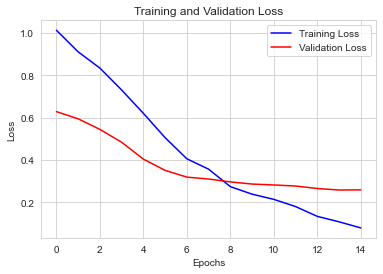

In [87]:
# Get the training loss values
training_loss = history.history['loss']

# Get the validation loss values
validation_loss = history.history['val_loss']

# Create a range for the x-axis (number of epochs)
epochs = range(len(training_loss))

# Plot the training loss
plt.plot(epochs, training_loss, 'b', label='Training Loss')

# Plot the validation loss
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')

# Add labels and title
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()
